### Table of Contents

# 1. Import Data

## 1.1 Import the needed libraries

In [1718]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy.stats import zscore
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


%matplotlib inline
pd.set_option('display.max_columns', None)

## 1.2 Import a integrate data

In [1719]:
df_crm = pd.read_csv('crm.csv')
df_mkt = pd.read_csv('mkt.csv')
df_sales = pd.read_excel('sales.xlsx')

In [1720]:
df = pd.merge(pd.merge(df_crm,df_sales,on='CustomerID',how="inner"),df_mkt,on="CustomerID",how="inner")

## 1.3 Set Index


In [1721]:
df.set_index('CustomerID',inplace = True)

## 1.4 Check and removing duplicates

In [1722]:
df[df.duplicated()] # checking duplicates

,Name,Birthyear,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
32924,Mrs. Wanda Terry,1986,Graduation,Divorced,41264.0,1,1,2020-10-03 00:00:00,61.0,70.0,20,165.0,40.0,0.0,7.0,2,3,1,3,7,0,0,0,0,0,0
8276,Mrs. Mary Jackson,1968,HighSchool,Married,118238.0,0,0,2020-10-13 00:00:00,42.0,5940.0,1002,9465.0,1100.0,1100.0,32.0,1,6,7,8,2,0,0,0,0,0,0
32966,Mr. Steven Baker,1961,HighSchool,Married,84974.0,0,1,2022-02-17 00:00:00,56.0,2610.0,840,2160.0,840.0,960.0,133.0,3,6,5,9,3,0,0,0,0,0,0
5627,Mr. Jonathan Clark,1988,Graduation,Married,40975.0,1,0,2022-04-28 00:00:00,31.0,130.0,0,120.0,20.0,20.0,5.0,1,3,1,4,3,0,0,0,0,0,0
29357,Mr. Eric Springer,1972,PhD,Married,77778.0,0,1,2022-04-19 00:00:00,92.0,1240.0,60,315.0,20.0,20.0,33.0,1,5,2,4,6,0,0,1,0,0,0
26891,Mr. Sam Peake,1992,Graduation,Married,74147.0,1,0,2022-03-21 00:00:00,13.0,610.0,320,915.0,20.0,240.0,78.0,2,6,3,2,6,0,1,0,0,0,0
21269,Mr. Nathan Glover,1971,Graduation,Married,91241.0,0,1,2022-03-28 00:00:00,18.0,1780.0,220,2370.0,540.0,380.0,59.0,1,8,3,6,5,0,0,0,0,0,0
32777,Mr. Joe James,1967,Master,Married,101251.0,0,1,2021-12-30 00:00:00,26.0,7350.0,2780,4170.0,500.0,1760.0,66.0,2,8,8,6,3,0,1,0,0,0,0
26285,Mr. Oliver Sanderson,1986,Basic,Together,22345.0,1,0,2021-03-21 00:00:00,54.0,50.0,180,285.0,240.0,280.0,39.0,3,5,2,2,9,0,1,0,0,0,0


In [1723]:
df = df[~df.duplicated()] # drop duplicates rows

# 2. Explore Data

## 2.0 Data profiling

Se não quiserem instalar a biblioteca não corram esta secção. Caso contrário o comando para instalar é pip install ydata-profiling. No final **apagar esta secção**

In [1724]:
#from ydata_profiling import ProfileReport
#profile= ProfileReport (df, title= "DSML_Project")

In [1725]:
#profile.to_file('DSML_profile.html')

## 2.1 Basic Exploration

Q: _To check the number of columns and rows_ we used `shape` _attribute_

In [1726]:
df.shape

(7000, 26)

> A: _The dataset has **7000 rows** and **26 columns**_

__*Q*__: Check the name of the features of the dataset we used `columns` _attribute_

In [1727]:
df.columns

Index(['Name', 'Birthyear', 'Education', 'Marital_Status', 'Income',
       'Kid_Younger6', 'Children_6to18', 'Date_Adherence', 'Recency',
       'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks',
       'MntDesserts', 'MntAdditionalRequests', 'NumOfferPurchases',
       'NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases',
       'NumAppVisitsMonth', 'Complain', 'Response_Cmp1', 'Response_Cmp2',
       'Response_Cmp3', 'Response_Cmp4', 'Response_Cmp5'],
      dtype='object')

> A: The dataset has the following columns/features names: <br>
        >Index. CustomerID
        >1. 'Name' <br>
        >2. 'Birthyear'<br>
        >3. 'Education'<br>
        >4. 'Marital_Status'<br>
        >5. 'Income'<br>
        >6. 'Kid_Younger6'<br>
        >7. 'Children_6to18'<br>
        >8. 'Date_Adherence'<br>
        >9. 'Recency'<br>
        >10. 'MntMeat&Fish'<br>
        >11. 'MntEntries'<br>
        >12. 'MntVegan&Vegetarian'<br>
        >13. 'MntDrinks'<br>
        >14. 'MntDesserts'<br>
        >15. 'MntAdditionalRequests'<br>
        >16. 'NumOfferPurchases'<br>
        >17. 'NumAppPurchases'<br>
        >18. 'NumTakeAwayPurchases'<br>
        >19. 'NumStorePurchases'<br>
        >20. 'NumAppVisitsMonth'<br>
        >21. 'Complain'<br>
        >22. 'Response_Cmp1'<br>
        >23. 'Response_Cmp2'<br>
        >24. 'Response_Cmp3'<br>
        >25. 'Response_Cmp4'<br>
        >26. 'Response_Cmp5'<br>

Q: First glance of the dataset using `head` and `tail` methods to check the first and last 5 rows.

In [1728]:
df.head(3)

,Name,Birthyear,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,1981,Graduation,Single,113947.0,0,0,2021-01-09 00:00:00,43.0,4640.0,3380,5700.0,2240.0,562.0,154.0,2,10,7,7,4,0,0,1,0,0,0
19070,Miss Grace Black,1974,Graduation,Together,114297.0,0,0,2021-04-10 00:00:00,74.0,7080.0,3680,7620.0,1840.0,1220.0,46.0,1,5,9,12,2,0,0,0,0,0,0
29888,Mr. Gavin Morrison,1960,PhD,Together,115476.0,0,0,2022-01-12 00:00:00,85.0,4130.0,380,4890.0,3640.0,380.0,28.0,1,5,5,7,1,0,0,0,0,0,0


In [1729]:
df.tail(3)

,Name,Birthyear,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
29186,Mr. Thomas Churchill,1967,PhD,Together,56039.0,0,1,2021-12-15 00:00:00,30.0,540.0,0,135.0,0.0,0.0,5.0,2,3,1,4,6,0,0,0,0,0,0
23312,Miss Angela Murray,1989,Graduation,Single,44867.0,1,0,2020-11-12 00:00:00,8.0,80.0,120,210.0,120.0,100.0,17.0,1,3,1,3,8,0,0,0,0,0,0
15581,Miss Diana Taylor,1960,Graduation,Single,124379.0,0,0,2021-02-04 00:00:00,80.0,7280.0,422,1692.0,3760.0,1880.0,235.0,1,6,12,11,2,0,0,0,1,1,0


Q: To check the basic information of the dataset we've used the `info` method

In [1730]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 14594 to 15581
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   7000 non-null   object 
 1   Birthyear              7000 non-null   int64  
 2   Education              6986 non-null   object 
 3   Marital_Status         7000 non-null   object 
 4   Income                 7000 non-null   float64
 5   Kid_Younger6           7000 non-null   int64  
 6   Children_6to18         7000 non-null   int64  
 7   Date_Adherence         7000 non-null   object 
 8   Recency                6977 non-null   float64
 9   MntMeat&Fish           7000 non-null   float64
 10  MntEntries             7000 non-null   int64  
 11  MntVegan&Vegetarian    7000 non-null   float64
 12  MntDrinks              6972 non-null   float64
 13  MntDesserts            7000 non-null   float64
 14  MntAdditionalRequests  7000 non-null   float64
 15 

>A: We can observe the data type of the dataset and the how many of features per data type  `dtypes: float64 - (7), int64 - (15), object - (4)`, the memory usage of `1.4+MB`, and the non-null values present per columns. <br>
> Using only `info` method we understand that `'Education', 'Recency', 'MntDrinks'` have __14, 23, 28 null values__ that require some action.

# 2.2 Statistical Exploration

## 2.2.1 Numerical Variables

In [1731]:
df.describe()

,Birthyear,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5
count,7000.000000,7000.000000,7000.000000,7000.000000,6977.000000,7000.000000,7000.000000,7000.000000,6972.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,1976.451429,77988.962407,0.440571,0.490571,49.235058,3079.523800,534.749429,2785.050786,545.657544,540.656029,42.556186,2.448429,6.015714,3.834571,5.790571,5.278286,0.010286,0.079143,0.073286,0.083000,0.065857,0.014286
std,11.996270,35409.810253,0.543477,0.542174,28.922688,3370.377166,787.846684,3908.718244,805.149088,802.221866,49.650747,2.306968,2.745537,3.331142,3.295708,2.748596,0.100903,0.269981,0.260624,0.275902,0.248050,0.118675
min,1948.000000,2493.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1967.000000,51586.250000,0.000000,0.000000,24.000000,250.000000,40.000000,240.000000,40.000000,40.000000,9.000000,1.000000,4.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1977.000000,77190.000000,0.000000,0.000000,49.000000,1820.000000,180.000000,1110.000000,180.000000,180.000000,24.000000,2.000000,6.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1985.000000,102016.250000,1.000000,1.000000,74.000000,5070.000000,680.000000,3795.000000,700.000000,680.000000,57.000000,3.000000,8.000000,5.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2005.000000,237639.725000,2.000000,2.000000,99.000000,14980.000000,3980.000000,25974.000000,3980.000000,3980.000000,249.000000,16.000000,13.000000,24.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> _The describe return we can get a first glance and make some conclusion:_

>__Birthyear__ - could originate an Age column for readability purposes<br>
__Income__ - Min and Max are very far from each other and far from the mean value which could indicate outliers<br>
__Recency__ - 6977 valid values, hence we should look in deep and decide on how to minimize that effect of missing values<br>
__MntMeat&Fish__ - Min and Max are distant from each other and have high standard deviation which could effect some future conclusion<br>
__MntEntries__ - Again has high standard deviation that we should analyze, Min and Max far apart, similar to MntMeat&Fish<br>
__MntVegan&Vegetarian__ - Similar to the previous two Mnt columns<br>
__MntDrinks, MntDesserts__ - Seems to be very similar between them<br>
__MntAdditionalRequests__ - The max value standard deviation seems high and also the max value very far apart from the mean<br>
__NumOfferPurchases, NumTakeAwayPurchases, NumAppVisitsMonth__  - Have a max value to distante from the mean that could be true but we need to take into account<br>
__NumAppPurchases, SumStorePurchases__ - Seems does not have strange summary statistcs<br>
__Kid_Younger6, Children_6to18__ - 75% of clients have at least one child

**Q**: Skewness of each variable 

In [1732]:
df.skew()

/var/folders/zb/r83qxb_974vbg2bs9xjz4yvh0000gp/T/ipykernel_68875/547062910.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew()


Birthyear               -0.092478
Income                   0.844721
Kid_Younger6             0.693587
Children_6to18           0.451693
Recency                  0.017676
MntMeat&Fish             1.148862
MntEntries               2.087220
MntVegan&Vegetarian      2.486897
MntDrinks                2.046308
MntDesserts              2.057811
MntAdditionalRequests    1.826522
NumOfferPurchases        2.860514
NumAppPurchases          0.525873
NumTakeAwayPurchases     2.254158
NumStorePurchases        0.623254
NumAppVisitsMonth        1.005192
Complain                 9.709429
Response_Cmp1            3.118572
Response_Cmp2            3.275500
Response_Cmp3            3.023677
Response_Cmp4            3.501448
Response_Cmp5            8.187993
dtype: float64

Concerning the variables' skewness, we can conclude the following:
- `Moderate skewness (between |0.5| and |1.0|)`: Birthyear, Income, Kid_Younger6, Children_6to18, Recency, NumAppPurchases, NumStorePurchases, NumAppVisitsMonth
- `High skewness (higher than |1.0|)`: MntMeat&Fish, MntEntries, MntVegan&Vegetarian, MntDrinks, MntDesserts, MntAdditionalRequests, NumOfferPurchases, NumTakeAwayPurchases, Complain, Response_Cmp1, Response_Cmp2, Response_Cmp3, Response_Cmp4, Response_Cmp5

In [1733]:
df.kurt()

/var/folders/zb/r83qxb_974vbg2bs9xjz4yvh0000gp/T/ipykernel_68875/3952544226.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.kurt()


Birthyear                -0.857341
Income                    2.649035
Kid_Younger6             -0.651127
Children_6to18           -0.973333
Recency                  -1.197978
MntMeat&Fish              0.532098
MntEntries                4.096167
MntVegan&Vegetarian       8.431538
MntDrinks                 3.839256
MntDesserts               3.813464
MntAdditionalRequests     3.084190
NumOfferPurchases        10.997946
NumAppPurchases          -0.222899
NumTakeAwayPurchases      8.582138
NumStorePurchases        -0.694327
NumAppVisitsMonth         4.992870
Complain                 92.299387
Response_Cmp1             7.727700
Response_Cmp2             8.731398
Response_Cmp3             7.144665
Response_Cmp4            10.263068
Response_Cmp5            65.061813
dtype: float64

Features with kurtosis higher than 3 could indicate presence of outliers, hence we should have special considerantion with the following features:
>MntEntries, MntVegan&Vegetarian, MntDrinks, MntDesserts, NumOfferPurchases, NumAppVisitsMonth

Note: Binomial Variables Complain, and Response_Cmp1 the kurtosis we will not consider as outliers

## 2.2.2 Categorical Values

In [1734]:
df.describe(include = object)

,Name,Education,Marital_Status,Date_Adherence
count,7000,6986,7000,7000
unique,6241,9,10,701
top,Mr. Stewart Grant,Graduation,Married,2020-09-19 00:00:00
freq,3,3497,2830,23


> We can conclude that the education as **14 missing** values

#### Level/Possible values of Categorical Features

### `Name` prefix unique values and count

In [1735]:
df['Name'].str.partition(" ")[0].value_counts()

Mr.     5133
Miss    1469
Mrs.     398
Name: 0, dtype: int64

With the prefix we can generate a `gender` feature to further explore the dataset. We will deal with that in the data transformation capther

#### **`Gender`** feature creation

In [1736]:
df["Gender"] = df['Name'].str.partition(" ")[0]
df = df.replace({"Gender":{"Mr.": 1,"Miss": 0,"Mrs.": 0}})

### `Education` unique values and count

In [1737]:
df["Education"].value_counts()

Graduation    3497
PhD           1494
Master        1135
HighSchool     663
Basic          179
master           7
graduation       7
phd              2
highschool       2
Name: Education, dtype: int64

We have some issues that will need trasformatioin:<br>
- Graduation, Master, HighSchool are written in different ways<br>
- `Basic` and `HighSchool` need different levels?

#### Education standardization

In [1738]:
df = df.replace({"Education":{"master":"Master", "graduation":"Graduation", "phd":"PhD","highschool":"HighSchool"}})

### `Marital_Status` unique values and count

In [1739]:
df["Marital_Status"].value_counts()

Married     2830
Together    1683
Single      1525
Divorced     637
Widow        243
married       36
together      23
single        13
divorced       8
widow          2
Name: Marital_Status, dtype: int64

Similarly to previous feature we also have some issues that need transformation:<br>
- Married, Together, Single, Divorced and Widow are written with lower and capital letters
- We could also consider that Married and Together are similar and joined them in the same level<br>

#### Marital_Status standardization

In [1740]:
df = df.replace({"Marital_Status":{"married":"Married", "together":"Married", "single":"Single","widow":"Widow","divorced":"Divorced","Together":"Married"}})
df["Marital_Status"].value_counts()

Married     4572
Single      1538
Divorced     645
Widow        245
Name: Marital_Status, dtype: int64

`Date_Adherence` unqiue values and count

In [1741]:
df["Date_Adherence"].value_counts()

2020-09-19    23
2021-08-22    20
2021-07-30    20
2022-05-23    20
2021-08-21    19
              ..
2021-03-09     3
2020-09-18     2
2020-07-30     2
2020-08-29     2
2021-03-22     2
Name: Date_Adherence, Length: 701, dtype: int64

`Date_Adherence` is a date and will need transformation to a date format for further exploration

## 2.3 Visual Exploration

### 2.3.1 Numerical Variables

## 2.4. In-Depth Exploration

# 3. Preprocess Data

### 3.1.2. Missing Values

In [1742]:
Response_is_null = df["Response_Cmp1"].isna().sum() + df["Response_Cmp2"].isna().sum() + df["Response_Cmp3"].isna().sum() + df["Response_Cmp4"].isna().sum()
Response_is_null == 0

True

In [1743]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 14594 to 15581
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   7000 non-null   object 
 1   Birthyear              7000 non-null   int64  
 2   Education              6986 non-null   object 
 3   Marital_Status         7000 non-null   object 
 4   Income                 7000 non-null   float64
 5   Kid_Younger6           7000 non-null   int64  
 6   Children_6to18         7000 non-null   int64  
 7   Date_Adherence         7000 non-null   object 
 8   Recency                6977 non-null   float64
 9   MntMeat&Fish           7000 non-null   float64
 10  MntEntries             7000 non-null   int64  
 11  MntVegan&Vegetarian    7000 non-null   float64
 12  MntDrinks              6972 non-null   float64
 13  MntDesserts            7000 non-null   float64
 14  MntAdditionalRequests  7000 non-null   float64
 15 

In [1744]:
df.isna().sum()

Name                      0
Birthyear                 0
Education                14
Marital_Status            0
Income                    0
Kid_Younger6              0
Children_6to18            0
Date_Adherence            0
Recency                  23
MntMeat&Fish              0
MntEntries                0
MntVegan&Vegetarian       0
MntDrinks                28
MntDesserts               0
MntAdditionalRequests     0
NumOfferPurchases         0
NumAppPurchases           0
NumTakeAwayPurchases      0
NumStorePurchases         0
NumAppVisitsMonth         0
Complain                  0
Response_Cmp1             0
Response_Cmp2             0
Response_Cmp3             0
Response_Cmp4             0
Response_Cmp5             0
Gender                    0
dtype: int64

- **`Education`**, **`Recency`**, **`MntDrinks`** and **`MntTotal`** (due to dependancy of `MntDrinks`) have missing values

#### Filling the missing values

Fill `Education` with the mode

In [1745]:
df["Education"].fillna(df["Education"].mode()[0], inplace = True)

Fill `Recency` with the median value

In [1746]:
df["Recency"].fillna(df["Recency"].mean(), inplace = True)

In [1747]:
df_mnt = df[[ 'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks',
       'MntDesserts', 'MntAdditionalRequests']]

imputer = KNNImputer(n_neighbors=3)
array_impute = imputer.fit_transform(df_mnt)
df_mnt = pd.DataFrame(array_impute, columns = df_mnt.columns)

In [1748]:
df["MntDrinks"] = df_mnt["MntDrinks"].values

In [1749]:
df.isna().sum()

Name                     0
Birthyear                0
Education                0
Marital_Status           0
Income                   0
Kid_Younger6             0
Children_6to18           0
Date_Adherence           0
Recency                  0
MntMeat&Fish             0
MntEntries               0
MntVegan&Vegetarian      0
MntDrinks                0
MntDesserts              0
MntAdditionalRequests    0
NumOfferPurchases        0
NumAppPurchases          0
NumTakeAwayPurchases     0
NumStorePurchases        0
NumAppVisitsMonth        0
Complain                 0
Response_Cmp1            0
Response_Cmp2            0
Response_Cmp3            0
Response_Cmp4            0
Response_Cmp5            0
Gender                   0
dtype: int64

## 3.2. Data Transformation

### 3.2.1. Create new Variables

### Utils

In [1750]:
df['NumPurchasesTotal'] = df['NumTakeAwayPurchases'] + df['NumStorePurchases'] + df['NumAppPurchases']

#### Creating Age variable from the Birthyear

In [1751]:
df['Age'] = df.Birthyear.apply(lambda x: date.today().year-x)

In [1752]:
df.drop('Birthyear', axis= 1, inplace = True)

#### Creating card adherence age variable from the Date adherence

In [1753]:
from datetime import datetime
df = df.replace({"Date_Adherence":{"2/29/2022": datetime.strptime("2022-03-01", '%Y-%m-%d')}}) #2022 is not a leap year, therefore 29/02/2022 is not a possible day

In [1754]:
df['daysAsCardClient'] = df['Date_Adherence'].apply(lambda x: (date.today() - x.date()).days)

In [1755]:
df.drop('Date_Adherence', axis= 1, inplace = True)

#### Fill Education

In [1756]:
df.head()

,Name,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,Graduation,Single,113947.0,0,0,43.0,4640.0,3380,5700.0,2240.0,562.0,154.0,2,10,7,7,4,0,0,1,0,0,0,0,24,42,826
19070,Miss Grace Black,Graduation,Married,114297.0,0,0,74.0,7080.0,3680,7620.0,1840.0,1220.0,46.0,1,5,9,12,2,0,0,0,0,0,0,0,26,49,735
29888,Mr. Gavin Morrison,PhD,Married,115476.0,0,0,85.0,4130.0,380,4890.0,3640.0,380.0,28.0,1,5,5,7,1,0,0,0,0,0,0,1,17,63,458
12221,Mr. Ryan Glover,Graduation,Married,101172.0,1,1,25.0,3590.0,0,1770.0,80.0,180.0,14.0,5,8,3,8,5,0,0,0,0,0,0,1,19,43,550
21107,Mr. Paul Anderson,HighSchool,Single,123128.0,0,0,64.0,5390.0,1126,9495.0,656.0,562.0,74.0,0,4,7,8,5,0,1,0,1,0,0,1,19,52,855


In [1757]:
edu_encode = pd.get_dummies(df.Education, drop_first= True) #TODO ver se nao ha formas melhores para tratar desta categoria
df = pd.concat([df, edu_encode], axis = 1)

In [1758]:
df.head()

,Name,Education,Marital_Status,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,Graduation,Single,113947.0,0,0,43.0,4640.0,3380,5700.0,2240.0,562.0,154.0,2,10,7,7,4,0,0,1,0,0,0,0,24,42,826,1,0,0,0
19070,Miss Grace Black,Graduation,Married,114297.0,0,0,74.0,7080.0,3680,7620.0,1840.0,1220.0,46.0,1,5,9,12,2,0,0,0,0,0,0,0,26,49,735,1,0,0,0
29888,Mr. Gavin Morrison,PhD,Married,115476.0,0,0,85.0,4130.0,380,4890.0,3640.0,380.0,28.0,1,5,5,7,1,0,0,0,0,0,0,1,17,63,458,0,0,0,1
12221,Mr. Ryan Glover,Graduation,Married,101172.0,1,1,25.0,3590.0,0,1770.0,80.0,180.0,14.0,5,8,3,8,5,0,0,0,0,0,0,1,19,43,550,1,0,0,0
21107,Mr. Paul Anderson,HighSchool,Single,123128.0,0,0,64.0,5390.0,1126,9495.0,656.0,562.0,74.0,0,4,7,8,5,0,1,0,1,0,0,1,19,52,855,0,1,0,0


In [1759]:
df.drop('Education', axis = 1, inplace = True)


In [1760]:
df.head()

,Name,Marital_Status,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,Single,113947.0,0,0,43.0,4640.0,3380,5700.0,2240.0,562.0,154.0,2,10,7,7,4,0,0,1,0,0,0,0,24,42,826,1,0,0,0
19070,Miss Grace Black,Married,114297.0,0,0,74.0,7080.0,3680,7620.0,1840.0,1220.0,46.0,1,5,9,12,2,0,0,0,0,0,0,0,26,49,735,1,0,0,0
29888,Mr. Gavin Morrison,Married,115476.0,0,0,85.0,4130.0,380,4890.0,3640.0,380.0,28.0,1,5,5,7,1,0,0,0,0,0,0,1,17,63,458,0,0,0,1
12221,Mr. Ryan Glover,Married,101172.0,1,1,25.0,3590.0,0,1770.0,80.0,180.0,14.0,5,8,3,8,5,0,0,0,0,0,0,1,19,43,550,1,0,0,0
21107,Mr. Paul Anderson,Single,123128.0,0,0,64.0,5390.0,1126,9495.0,656.0,562.0,74.0,0,4,7,8,5,0,1,0,1,0,0,1,19,52,855,0,1,0,0


#### Fill Maritial Status

In [1761]:
marital_encode = pd.get_dummies(df.Marital_Status, drop_first= True)
df = pd.concat([df, marital_encode], axis = 1)

In [1762]:
df.head()

,Name,Marital_Status,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,Single,113947.0,0,0,43.0,4640.0,3380,5700.0,2240.0,562.0,154.0,2,10,7,7,4,0,0,1,0,0,0,0,24,42,826,1,0,0,0,0,1,0
19070,Miss Grace Black,Married,114297.0,0,0,74.0,7080.0,3680,7620.0,1840.0,1220.0,46.0,1,5,9,12,2,0,0,0,0,0,0,0,26,49,735,1,0,0,0,1,0,0
29888,Mr. Gavin Morrison,Married,115476.0,0,0,85.0,4130.0,380,4890.0,3640.0,380.0,28.0,1,5,5,7,1,0,0,0,0,0,0,1,17,63,458,0,0,0,1,1,0,0
12221,Mr. Ryan Glover,Married,101172.0,1,1,25.0,3590.0,0,1770.0,80.0,180.0,14.0,5,8,3,8,5,0,0,0,0,0,0,1,19,43,550,1,0,0,0,1,0,0
21107,Mr. Paul Anderson,Single,123128.0,0,0,64.0,5390.0,1126,9495.0,656.0,562.0,74.0,0,4,7,8,5,0,1,0,1,0,0,1,19,52,855,0,1,0,0,0,1,0


In [1763]:
df.drop('Marital_Status', axis= 1, inplace = True)

#### Create MntTotal

In [1764]:
df["MntTotal"] = df['MntMeat&Fish'] + df['MntEntries'] + df['MntVegan&Vegetarian'] + df['MntDrinks'] + df['MntDesserts'] + df['MntAdditionalRequests']
df["MntTotal"]
# em falta Mnt Add Requests

CustomerID
14594    16676.0
19070    21486.0
29888    13448.0
12221     5634.0
21107    17303.0
          ...   
30686    15665.0
17210    24246.0
29186      680.0
23312      647.0
15581    15269.0
Name: MntTotal, Length: 7000, dtype: float64

#### Create Mnt Pday Card

In [1765]:
df['Mnt_pday_card']= df.MntTotal/df.daysAsCardClient

#### Create Response Campaigns

In [1766]:
df['Response_Campaigns'] = df['Response_Cmp1'] + df['Response_Cmp2'] + df['Response_Cmp3'] + df['Response_Cmp4'] + df[
       'Response_Cmp5']

#### Create Total Kids

In [1767]:
df["Total_Kids"] = df["Kid_Younger6"] + df["Children_6to18"]

#### Create Has Kids

In [1768]:
df["has_Kids"] = df["Total_Kids"].apply(lambda x: 0 if x == 0 else 1)
df["has_Kids"]

CustomerID
14594    0
19070    0
29888    0
12221    1
21107    0
        ..
30686    0
17210    0
29186    1
23312    1
15581    0
Name: has_Kids, Length: 7000, dtype: int64

#### Create age_bins

In [1769]:
df["age_bins"] = pd.cut(df["Age"], bins = 5)
age_bin = pd.get_dummies(df['age_bins'],prefix='age')
df = pd.concat([df,age_bin], axis=1)
df.drop(['age_bins'],axis=1, inplace=True)

In [1770]:
df

,Name,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,MntTotal,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,113947.0,0,0,43.0,4640.0,3380,5700.0,2240.0,562.0,154.0,2,10,7,7,4,0,0,1,0,0,0,0,24,42,826,1,0,0,0,0,1,0,16676.0,20.188862,1,0,0,0,0,1,0,0
19070,Miss Grace Black,114297.0,0,0,74.0,7080.0,3680,7620.0,1840.0,1220.0,46.0,1,5,9,12,2,0,0,0,0,0,0,0,26,49,735,1,0,0,0,1,0,0,21486.0,29.232653,0,0,0,0,0,1,0,0
29888,Mr. Gavin Morrison,115476.0,0,0,85.0,4130.0,380,4890.0,3640.0,380.0,28.0,1,5,5,7,1,0,0,0,0,0,0,1,17,63,458,0,0,0,1,1,0,0,13448.0,29.362445,0,0,0,0,0,0,1,0
12221,Mr. Ryan Glover,101172.0,1,1,25.0,3590.0,0,1770.0,80.0,180.0,14.0,5,8,3,8,5,0,0,0,0,0,0,1,19,43,550,1,0,0,0,1,0,0,5634.0,10.243636,0,2,1,0,0,1,0,0
21107,Mr. Paul Anderson,123128.0,0,0,64.0,5390.0,1126,9495.0,656.0,562.0,74.0,0,4,7,8,5,0,1,0,1,0,0,1,19,52,855,0,1,0,0,0,1,0,17303.0,20.237427,2,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30686,Mr. John Hughes,98968.0,0,0,66.0,9090.0,260,6015.0,260.0,0.0,40.0,1,6,6,11,2,0,0,0,0,0,0,1,23,29,493,0,0,0,1,0,0,0,15665.0,31.774848,0,0,0,1,0,0,0,0
17210,Mr. Brandon Simpson,109977.0,0,0,8.0,5870.0,1020,13470.0,3800.0,0.0,86.0,1,5,7,7,2,0,0,0,0,0,0,1,19,38,945,1,0,0,0,0,0,0,24246.0,25.657143,0,0,0,0,1,0,0,0
29186,Mr. Thomas Churchill,56039.0,0,1,30.0,540.0,0,135.0,0.0,0.0,5.0,2,3,1,4,6,0,0,0,0,0,0,1,8,56,486,0,0,0,1,1,0,0,680.0,1.399177,0,1,1,0,0,0,1,0


## Incoherencies


Verificar que todos os clientes que têm valores gastos têm compras registadas

In [1771]:
df[(df[['MntMeat&Fish', 'MntEntries',
        'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
        'MntAdditionalRequests']].sum(axis = 1) > 0) & (df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases']].sum(axis = 1) <= 0)]

,Name,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,MntTotal,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6185,Mr. Matt Clarkson,4609.600,2,0,32.0,19.0,10,73.5,10.0,28.0,3.2,15,0,0,0,20,0,0,0,0,0,0,1,0,32,827,0,0,1,0,1,0,0,143.7,0.173761,0,2,1,0,1,0,0,0
20405,Mr. Stephen Paterson,229052.725,0,1,0.0,80.0,2,55.5,0.0,2.0,0.3,0,0,0,0,1,0,0,0,0,0,0,1,0,56,913,0,0,1,0,1,0,0,139.8,0.153122,0,1,1,0,0,0,1,0
11126,Mr. Michael Arnold,228750.025,2,1,95.0,51.0,10,37.5,2.0,12.0,1.6,0,0,0,0,1,0,0,0,0,0,0,1,0,53,922,1,0,0,0,1,0,0,114.1,0.123753,0,3,1,0,0,0,1,0
5318,Mr. Liam MacDonald,3005.400,0,0,16.0,5.0,8,7.5,6.0,4.0,1.0,0,0,0,0,20,0,0,0,0,0,0,1,0,55,809,0,1,0,0,1,0,0,31.5,0.038937,0,0,0,0,0,0,1,0
6164,Mr. Anthony Grant,229113.325,1,0,38.0,11.0,0,7.5,0.0,0.0,0.1,0,0,0,0,1,0,0,0,0,0,0,1,0,40,826,0,0,0,1,1,0,0,18.6,0.022518,0,1,1,0,1,0,0,0
8780,Mr. Brandon Black,226439.025,0,0,35.0,6.0,16,45.0,52.0,34.0,6.0,0,0,0,0,1,0,0,0,0,0,0,1,0,23,984,0,1,0,0,0,1,0,159.0,0.161585,0,0,0,1,0,0,0,0
25079,Mr. Harry Dickens,5048.000,0,1,64.0,13.0,4,4.5,0.0,2.0,0.0,15,0,0,0,20,0,0,0,0,0,0,1,0,64,946,0,0,0,1,1,0,0,23.5,0.024841,0,1,1,0,0,0,0,1
23297,Mr. Harry Newman,3909.600,1,1,29.0,12.0,0,4.5,0.0,0.0,0.3,15,0,0,0,20,0,0,0,0,0,0,1,0,43,848,1,0,0,0,1,0,0,16.8,0.019811,0,2,1,0,0,1,0,0
34565,Miss Jasmine Russell,7644.800,1,1,15.0,36.0,2,91.5,62.0,38.0,13.2,15,0,0,0,19,0,1,0,0,0,0,0,0,61,656,0,1,0,0,0,1,0,242.7,0.369970,1,2,1,0,0,0,1,0


Alterar as linhas que não têm compras registadas e valor gasto para que o valor gasto seja 0

In [1772]:
# como justificar a atribuição de [0,0,0,0,0,0] às variaveis de monetary?

df.loc[(df[['MntMeat&Fish', 'MntEntries',
            'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
            'MntAdditionalRequests']].sum(axis = 1) > 0) & (df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases']].sum(axis = 1) <= 0),['MntMeat&Fish','MntEntries','MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts','MntAdditionalRequests']] = [0,0,0,0,0,0] #TODO dar drop das linhas que não têm a condição acima

In [1773]:
df[(df[['MntMeat&Fish', 'MntEntries',
        'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
        'MntAdditionalRequests']].sum(axis = 1) > 0) & (df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases']].sum(axis = 1) <= 0)] # confirmação do ajuste

,Name,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,MntTotal,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Ver se não há mais compras com ofertas do que compras totais

In [1774]:
df[(df['NumOfferPurchases'] > df[['NumAppPurchases','NumTakeAwayPurchases','NumStorePurchases']].sum(axis=1))]

,Name,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,MntTotal,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6185,Mr. Matt Clarkson,4609.6,2,0,32.0,0.0,0,0.0,0.0,0.0,0.0,15,0,0,0,20,0,0,0,0,0,0,1,0,32,827,0,0,1,0,1,0,0,143.7,0.173761,0,2,1,0,1,0,0,0
7733,Mr. Jonathan Peake,10214.7,0,1,53.0,991.0,72,217.5,24.0,72.0,1.2,15,1,1,0,20,0,0,0,0,0,0,1,2,40,633,0,0,1,0,1,0,0,1377.7,2.176461,0,1,1,0,1,0,0,0
11753,Mr. Andrew Thomson,12680.0,0,0,67.0,450.0,60,1126.5,266.0,32.0,4.4,15,1,1,0,19,0,1,0,1,0,0,1,2,68,797,1,0,0,0,1,0,0,1938.9,2.432748,2,0,0,0,0,0,0,1
7679,Miss Carol Clark,11211.9,1,0,2.0,739.0,214,463.5,214.0,160.0,3.5,15,0,1,1,20,0,0,0,0,0,0,0,2,27,928,1,0,0,0,1,0,0,1794.0,1.933190,0,1,1,1,0,0,0,0
20819,Mr. Colin Forsyth,7875.9,0,2,94.0,263.0,10,349.5,106.0,82.0,8.3,15,1,1,1,20,0,0,0,0,0,0,1,3,48,970,1,0,0,0,1,0,0,818.8,0.844124,0,2,1,0,0,1,0,0
12011,Mr. Keith Mills,8503.6,0,0,70.0,1046.0,0,31.5,0.0,0.0,12.9,15,0,0,1,20,0,0,1,1,0,1,1,1,56,407,1,0,0,0,1,0,0,1090.4,2.679115,3,0,0,0,0,0,1,0
31391,Mr. Justin Forsyth,9709.1,0,0,26.0,304.0,184,265.5,170.0,98.0,4.9,15,0,0,1,19,0,0,0,0,0,0,1,1,65,436,0,0,0,1,0,0,1,1026.4,2.354128,0,0,0,0,0,0,0,1
26018,Mr. Alan Sanderson,9539.3,1,1,40.0,118.0,36,121.5,62.0,30.0,3.6,15,1,0,1,19,0,0,0,0,0,0,1,2,47,315,1,0,0,0,0,1,0,371.1,1.178095,0,2,1,0,0,1,0,0
33314,Mr. Michael Parsons,10468.8,0,1,10.0,851.0,170,237.0,194.0,72.0,6.0,15,1,1,1,20,0,0,1,0,0,0,1,3,41,880,0,0,1,0,1,0,0,1530.0,1.738636,1,1,1,0,0,1,0,0


In [1775]:
# será esta a abordagem mais acertada, isto é, assumir que todas as compras deste cliente foram "OfferPurchases"?

df.loc[(df['NumOfferPurchases'] > df[['NumAppPurchases','NumTakeAwayPurchases','NumStorePurchases']].sum(axis=1)),'NumOfferPurchases'] = df['NumAppPurchases'] + df['NumTakeAwayPurchases'] + df['NumStorePurchases']

In [1776]:
df[(df['NumOfferPurchases'] > df[['NumAppPurchases','NumTakeAwayPurchases','NumStorePurchases']].sum(axis=1))] # confirmação do ajuste

,Name,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,MntTotal,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### 3.1.2 Outliers

In [1777]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
#ax1.boxplot(df['MntVegan&Vegetarian'])
#ax2.boxplot(df['Income'])

In [1778]:
df.drop(df[abs(zscore(df['MntVegan&Vegetarian'])) > 3].index,
        inplace=True)
df.drop(df[abs(zscore(df['Income'])) > 3].index, inplace=True)


In [1779]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
#ax1.boxplot(df['MntVegan&Vegetarian'])
#ax2.boxplot(df['Income'])

# 3.1.1 Skewness Correction

In [1780]:
#TODO Ver se o sklearn nao tem funçao para fazer isto. ver sklearn.preprocessing, meter depois de outliers/incoherencies

In [1781]:
df['MntMeat&Fish'] = df['MntMeat&Fish'].apply(lambda x: np.log10(x+1))
df['MntVegan&Vegetarian'] = df['MntVegan&Vegetarian'].apply(lambda x: np.log10(x+1))
df['MntEntries'] = df['MntEntries'].apply(lambda x: np.log10(x+1))
df['MntDrinks'] = df['MntDrinks'].apply(lambda x: np.log10(x+1))
df['MntDesserts'] = df['MntDesserts'].apply(lambda x: np.log10(x+1))
df['MntAdditionalRequests'] = df['MntAdditionalRequests'].apply(lambda x: np.log10(x+1))
df['NumOfferPurchases'] = df['NumOfferPurchases'].apply(lambda x: np.log10(x+1))
df['NumTakeAwayPurchases'] = df['NumTakeAwayPurchases'].apply(lambda x: np.log10(x+1))
df['Complain'] = df['Complain'].apply(lambda x: np.log10(x+1))
df['Response_Cmp1'] = df['Response_Cmp1'].apply(lambda x: np.log10(x+1))
df['Response_Cmp2'] = df['Response_Cmp2'].apply(lambda x: np.log10(x+1))
df['Response_Cmp3'] = df['Response_Cmp3'].apply(lambda x: np.log10(x+1))
df['Response_Cmp4'] = df['Response_Cmp4'].apply(lambda x: np.log10(x+1))
df['Response_Cmp5'] = df['Response_Cmp5'].apply(lambda x: np.log10(x+1))

## Data Review

Ver a dataframe no seu estado final
Drop: Id, name, birthyear, date_adherence, total_kids, mntTotal

In [1782]:
df.head()

,Name,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,MntTotal,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,Miss Leah Lewis,113947.0,0,0,43.0,3.666612,3.529045,3.755951,3.350442,2.750508,2.190332,0.477121,10,0.903090,7,4,0.0,0.00000,0.30103,0.00000,0.0,0.0,0,24,42,826,1,0,0,0,0,1,0,16676.0,20.188862,1,0,0,0,0,1,0,0
19070,Miss Grace Black,114297.0,0,0,74.0,3.850095,3.565966,3.882012,3.265054,3.086716,1.672098,0.301030,5,1.000000,12,2,0.0,0.00000,0.00000,0.00000,0.0,0.0,0,26,49,735,1,0,0,0,1,0,0,21486.0,29.232653,0,0,0,0,0,1,0,0
29888,Mr. Gavin Morrison,115476.0,0,0,85.0,3.616055,2.580925,3.689398,3.561221,2.580925,1.462398,0.301030,5,0.778151,7,1,0.0,0.00000,0.00000,0.00000,0.0,0.0,1,17,63,458,0,0,0,1,1,0,0,13448.0,29.362445,0,0,0,0,0,0,1,0
12221,Mr. Ryan Glover,101172.0,1,1,25.0,3.555215,0.000000,3.248219,1.908485,2.257679,1.176091,0.778151,8,0.602060,8,5,0.0,0.00000,0.00000,0.00000,0.0,0.0,1,19,43,550,1,0,0,0,1,0,0,5634.0,10.243636,0,2,1,0,0,1,0,0
21107,Mr. Paul Anderson,123128.0,0,0,64.0,3.731669,3.051924,3.977541,2.817565,2.750508,1.875061,0.000000,4,0.903090,8,5,0.0,0.30103,0.00000,0.30103,0.0,0.0,1,19,52,855,0,1,0,0,0,1,0,17303.0,20.237427,2,0,0,0,0,1,0,0


In [1783]:
df.describe()

,Income,Kid_Younger6,Children_6to18,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,Response_Cmp1,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Gender,NumPurchasesTotal,Age,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,MntTotal,Mnt_pday_card,Response_Campaigns,Total_Kids,has_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
count,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000,6883.000000
mean,76137.597908,0.441377,0.490920,49.205202,3.022516,2.030098,2.968319,2.030089,2.027103,1.356931,0.468531,6.095598,0.600186,5.865175,5.354642,0.003061,0.023923,0.022043,0.024667,0.019637,0.004199,0.732965,15.662792,46.534215,636.549906,0.502252,0.095453,0.163010,0.213860,0.653639,0.220398,0.034287,7363.543581,12.337494,0.313817,0.932297,0.704780,0.082232,0.262386,0.319919,0.242917,0.092547
std,30999.969915,0.543260,0.542335,28.858060,0.838670,1.075011,0.717196,1.082240,1.079137,0.549572,0.203817,2.682217,0.247079,3.253837,2.705418,0.030205,0.081426,0.078425,0.082571,0.074341,0.035305,0.442443,7.218900,11.993197,202.901297,0.500031,0.293860,0.369402,0.410059,0.475844,0.414545,0.181980,7449.544705,13.530916,0.678708,0.752642,0.456175,0.274737,0.439963,0.466479,0.428877,0.289817
min,2493.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,290.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.800000,0.019811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51260.000000,0.000000,0.000000,24.000000,2.416641,1.612784,2.382017,1.612784,1.612784,1.000000,0.301030,4.000000,0.301030,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,38.000000,461.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,811.500000,1.466369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,76545.000000,0.000000,0.000000,49.000000,3.272074,2.257679,3.039811,2.257679,2.257679,1.397940,0.477121,6.000000,0.602060,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,16.000000,46.000000,631.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4563.000000,7.295381,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,101013.000000,1.000000,1.000000,74.000000,3.707655,2.838217,3.558228,2.845718,2.833147,1.770852,0.602060,8.000000,0.778151,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,22.000000,56.000000,812.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,12559.000000,19.486340,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,153703.000000,2.000000,2.000000,99.000000,4.175541,3.599992,4.159296,3.599992,3.599992,2.397940,1.204120,13.000000,1.397940,13.000000,20.000000,0.301030,0.301030,0.301030,0.301030,0.301030,0.301030,1.000000,36.000000,75.000000,989.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,33256.000000,89.894915,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Utilizar df como base para treinos/clustering

In [1784]:
df.drop(['Name'], axis = 1, inplace = True)

In [1785]:
df.columns

Index(['Income', 'Kid_Younger6', 'Children_6to18', 'Recency', 'MntMeat&Fish',
       'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
       'MntAdditionalRequests', 'NumOfferPurchases', 'NumAppPurchases',
       'NumTakeAwayPurchases', 'NumStorePurchases', 'NumAppVisitsMonth',
       'Complain', 'Response_Cmp1', 'Response_Cmp2', 'Response_Cmp3',
       'Response_Cmp4', 'Response_Cmp5', 'Gender', 'NumPurchasesTotal', 'Age',
       'daysAsCardClient', 'Graduation', 'HighSchool', 'Master', 'PhD',
       'Married', 'Single', 'Widow', 'MntTotal', 'Mnt_pday_card',
       'Response_Campaigns', 'Total_Kids', 'has_Kids', 'age_(17.943, 29.4]',
       'age_(29.4, 40.8]', 'age_(40.8, 52.2]', 'age_(52.2, 63.6]',
       'age_(63.6, 75.0]'],
      dtype='object')

# Feature Selection

As the problem is not a classification problem we will need to adapt our data so it can be used in classifiers. We will use Random Forest Classifiers as tools for feature selection, using MntTotal as the target variable, as our goal is to devise a marketing campaign that aims to increase sales

## Redução de Dimensões e Scaling
Pipeline para passar da df para uma df que se possa utilizar nos modelos de clustering.
1: Selecionar as colunas a partir da dataframe df. Criar uma copia com as colunas desejadas utilizando a função df_select
2: Aplicar a função scaling_dfs que aplica scaling à dataframe obtida no passo anterior e retorna uma df scaled
3: Escolher o método de redução de dimensoes a aplicar: PCA ou Feature selection com RandomForest
3.1.1 PCA: Utilizar a função PCA_graph_df para ver quantos principal components serão necessários para a variancia desejada
3.1.2 PCA: Utilizar a função create_PCA_df para aplicar PCA com o numero de componentes desejado à dataframe obtida em 2, obtendo uma df com o numero de colunas igual ao numero de principal components
3.2.1 Feature Selection com RandomForest: Utilizar a função RFR_feature_select para obter os nomes das colunas consideradas importantes e o MSE (para ver se a abordagem é viável). Atenção que a df utilizada para fazer feature selection deverá ser uma com as colunas desejadas mas **SEM SCALING**, para que não haja bleeding de informação.
3.2.2 Feature Selection com RandomForest: Utilizar a função selected_features_df para obter uma df sem scaling com apenas as colunas obtidas no passo anterior mais a coluna da target variable. **Aplicar o passo 2 apenas agora**



In [1786]:
def df_select(column_names: list, df: pd.DataFrame):
    df_train = df[column_names].copy()
    return df_train

In [1787]:
def scaling_dfs(df):
    scaler = MinMaxScaler()
    df_total_scaled = pd.DataFrame(scaler.fit_transform(df))
    return df_total_scaled

In [1788]:
def PCA_graph_df(df_scaled: pd.DataFrame, exp_variance: int):
    pca = PCA()
    pca.fit(df_scaled)
    var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

    plt.title("PCA Variance against num of Componmnets")
    plt.ylabel("Variance %")
    plt.xlabel("Number of componments")
    l = plt.axhline(exp_variance, color="red")

    plt.plot(var1)
    plt.grid()

In [1789]:
def create_PCA_df(n_components: int, df_scaled: pd.DataFrame):
    pca = PCA(n_components= n_components)
    pca_train=pca.fit_transform(df_scaled)
    return pca_train

In [1790]:
def RFR_feature_select(df: pd.DataFrame, target_var: str):

    x = df.drop([target_var], axis= 1).copy()
    y = df[target_var].copy()

    x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=1)

    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    scalerx = MinMaxScaler()
    scalery = MinMaxScaler()

    scalerx = scalerx.fit(x_train)
    scalery = scalery.fit(y_train)

    x_train = pd.DataFrame(scalerx.transform(x_train), columns= x.columns)
    x_test = pd.DataFrame(scalerx.transform(x_test), columns= x.columns)

    y_train = pd.DataFrame(scalery.transform(y_train))
    y_test = pd.DataFrame(scalery.transform(y_test))

    RFR = RandomForestRegressor(random_state= 1)
    RFR.fit(x_train, y_train)

    importances = pd.Series(RFR.feature_importances_, index= x_train.columns)
    threshold = importances.median()
    selected_features = x_train.reset_index(drop=True).loc[:, importances >= threshold]

    new_RFR = RandomForestRegressor(random_state=1)
    new_RFR.fit(selected_features, y_train)

    x_test= x_test[selected_features.columns]
    y_pred = new_RFR.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)

    return list(selected_features.columns), mse

In [1791]:
def selected_features_df(selected_columns: list, target_variable: str, df: pd.DataFrame):
    selected_columns = selected_columns.append(target_variable)
    selected_df = df[selected_columns].copy()
    return selected_df

## Exemplo

Neste exemplo serão utilizadas as colunas que vimos na quarta com o método PCA e o modelo kmeans

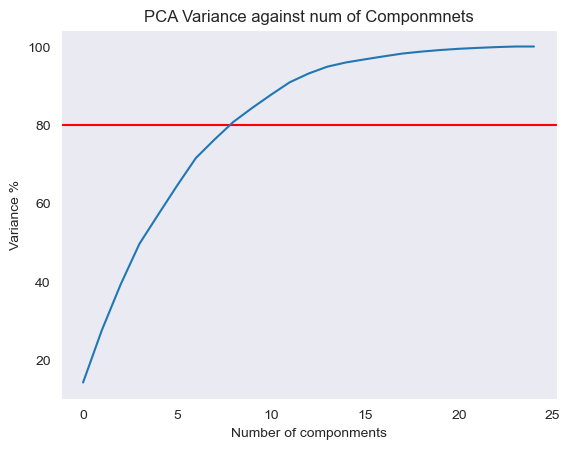

In [1792]:
kmeans_columns = ['Income', 'Recency', 'NumOfferPurchases', 'NumAppPurchases',
       'NumTakeAwayPurchases', 'NumStorePurchases', 'NumAppVisitsMonth',
       'Complain', 'Gender', 'daysAsCardClient',
       'Graduation', 'HighSchool', 'Master', 'PhD', 'Married', 'Single',
       'Widow', 'MntTotal', 'Response_Campaigns',
       'Total_Kids', 'age_(17.943, 29.4]', 'age_(29.4, 40.8]',
       'age_(40.8, 52.2]', 'age_(52.2, 63.6]', 'age_(63.6, 75.0]']
kmeans_df = df_select(column_names= kmeans_columns, df= df) #Step 1
kmeans_df_scaled = scaling_dfs(kmeans_df) #Step 2
PCA_graph_df(df_scaled= kmeans_df_scaled, exp_variance= 80) #Step 3.1.1

In [1793]:
kmeans_pca_df= create_PCA_df(n_components= 7, df_scaled= kmeans_df_scaled) #Step 3.1.2

## Treino de modelos e avaliação
Pipeline para passar de uma dataframe com dimensoes reduzidas para modelos de clustering e as suas métricas **Só funciona para modelos semelhantes a kmeans** #TODO fazer para modelos com outra estrutura

1: Criação do modelo. Utilizar os modelos do sklearn.cluster para obter um objeto **model** que se possa utilizar nas funções
2: Escolha do número de clusters utilizando uma das funções ..._nclusters
2.1 Elbow Method: Queremos selecionar o número de clusters que corresponde ao ponto da curva em que a derivada começa a ter declives menores
2.2 Total Sum of Squares Method: Queremos selecionar o número de clusters que maximiza o between_ss e minimza o within_ss

In [1794]:
def elbow_nclusters(model_type, dimensioned_df: pd.DataFrame, cluster_range: int):
    ks = range(1,cluster_range)
    inertias = []


    for k in ks:
        model = model_type(n_clusters = k).fit(dimensioned_df)
        inertias.append(model.inertia_)
    # Plot ks (x-axis) vs inertias (y-axis) using plt.plot().
    plt.plot(ks, inertias)

    # define the label for the x axis as 'number of clusters' using matplotlib.pyplot.xlabel
    plt.xlabel('number of clusters')
    # define the label for the y axis as 'inertia' using matplotlib.pyplot.ylabel
    plt.ylabel('inertia')
    # define the ticks on the x axis using the values of ks
    plt.xticks(ks)
    # call plt.show()
    plt.show()

In [1795]:
def sumsquares_nclusters(model_type,  dimensioned_df: pd.DataFrame, cluster_range: int):
    within_ss = []
    between_ss = []
    model_list = []
    n_cluster = range(1,cluster_range)

    ssc = pd.DataFrame({"model": n_cluster})
    ssc_melted = pd.melt(ssc, id_vars=["model"], var_name="measurement", value_name="value")

    for k in n_cluster:
        model = model_type(n_clusters=k)
        model.fit(dimensioned_df)
        within_ss.append(model.inertia_)
        between_ss.append(sum(np.min(
            cdist(dimensioned_df, model.cluster_centers_, 'euclidean'), axis=1)) / dimensioned_df.shape[0])
        model_list.append(model)

        ssc.loc[ssc["model"] == k, "within_ss"] = within_ss[-1]
        ssc.loc[ssc["model"] == k, "between_ss"] = between_ss[-1]

    ssc_melted = pd.melt(ssc, id_vars=["model"], var_name="measurement", value_name="value")

    plt.figure(figsize=(8, 6))
    sns.barplot(x="model", y=np.log10(ssc_melted["value"]),
                hue="measurement", data=ssc_melted)
    plt.title("Cluster Model Comparison")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Log10 Total Sum of Squares")
    plt.show()

## 4. Models

## Model Train

Modelos utilizados: kmeans
Modelos propostos: DBScan, Kmodes

In [1796]:
kmeans= KMeans(n_clusters = 4, max_iter =10000, random_state= 1)
kmeans.fit(kmeans_pca_df)
pca_train_label = kmeans.labels_
pca_train_label = pd.DataFrame(pca_train_label)

In [1797]:
df['cluster'] = kmeans.predict(kmeans_pca_df)

# variavel modelo visao monetary:
 Mnt_pday_card, has_Kids, Income, age_bins, 'Graduation', 'HighSchool', 'Master', 'PhD', 'Gender'

### Measuring distances between clusters

#TODO Experimentar com 3 clusters para ver se as distancias aumentam/diminuem para fundamentar a escolha do numero de clusters

In [1798]:
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(kmeans.cluster_centers_)
dists

array([[0.        , 1.41916706, 1.19844825, 1.40771522],
       [1.41916706, 0.        , 1.18986616, 1.6221646 ],
       [1.19844825, 1.18986616, 0.        , 1.50248031],
       [1.40771522, 1.6221646 , 1.50248031, 0.        ]])

### Visualization

In [1799]:
cluster0 = df[df.cluster == 0]
cluster1 = df[df.cluster == 1]
cluster2 = df[df.cluster == 2]
cluster3 = df[df.cluster == 3]

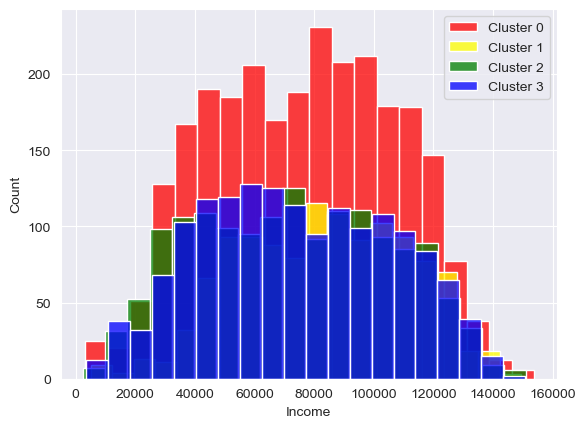

In [1800]:
sns.histplot(cluster0['Income'],color='red',label='Cluster 0', bins = 20)
sns.histplot(cluster1['Income'],color='yellow',label='Cluster 1', bins = 20)
sns.histplot(cluster2['Income'],color='green',label='Cluster 2', bins = 20)
sns.histplot(cluster3['Income'],color='blue',label='Cluster 3', bins = 20)
plt.legend()

# variavel modelo visao customer behaviour: NumOfferPurchases', 'NumAppPurchases',
       'NumTakeAwayPurchases', 'NumStorePurchases', 'NumAppVisitsMonth',
       'Complain', 'Gender', 'Income', 'Age', 'Graduation', 'HighSchool', 'Master', 'PhD', 'Married', 'Single',
       'Widow'

## Murilo - Análise

In [1801]:
#num_cols = ['Income', 'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts', 'MntAdditionalRequests']
#cat_cols = ['age_(17.943, 29.4]', 'age_(29.4, 40.8]', 'age_(40.8, 52.2]', 'age_(52.2, 63.6]', 'age_(63.6, 75.0]', 'Graduation', 'HighSchool', 'Master', 'PhD', 'Married', 'Single', 'Widow']

In [1802]:
num_cols = ['Income', 'Recency', 'MntMeat&Fish', 'MntEntries',
            'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
            'MntAdditionalRequests', 'NumOfferPurchases', 'NumAppPurchases',
            'NumTakeAwayPurchases', 'NumStorePurchases', 'NumAppVisitsMonth', 'Complain', 'daysAsCardClient']
cat_cols = ['Graduation', 'HighSchool', 'Master', 'PhD', 'Married', 'Single', 'Widow',
            'NumPurchasesTotal', 'Response_Campaigns', 'Total_Kids',
            'age_(17.943, 29.4]', 'age_(29.4, 40.8]', 'age_(40.8, 52.2]', 'age_(52.2, 63.6]', 'age_(63.6, 75.0]']

In [1803]:
kprototype_columns = []
kprototype_columns.extend(num_cols)
kprototype_columns.extend(cat_cols)

kprototype_df = df_select(column_names= kprototype_columns, df= df)

df_num = kprototype_df[num_cols]
df_cat = kprototype_df[cat_cols]

df_num = df_num.reset_index(drop=True)
df_cat = df_cat.reset_index(drop=True)

scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num)

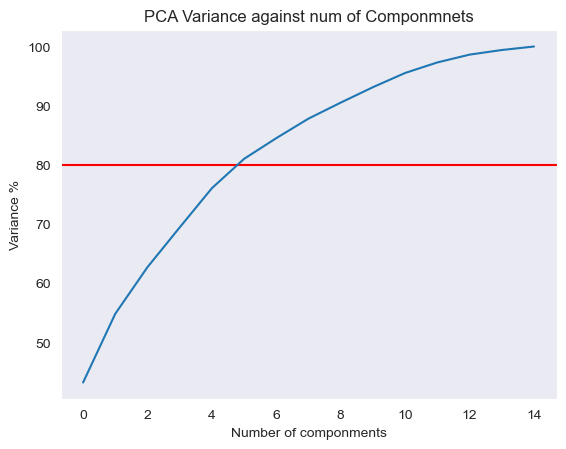

In [1804]:
PCA_graph_df(df_scaled= df_num_scaled, exp_variance= 80) #Step 3.1.1

In [1805]:
# Aplicando o PCA às colunas numéricas
pca = PCA(n_components=4)
df_num_pca = pca.fit_transform(df_num_scaled)

In [1806]:
# Sem o PCA às colunas numéricas
#df_num_pca = df_num_scaled

In [1807]:
# Concatenando as colunas numéricas do PCA com as colunas categóricas
df_combined = pd.concat([pd.DataFrame(df_num_pca), df_cat], axis=1)

In [1808]:
def plot_elbow(X, k_range):
    costs = []
    for k in k_range:
        kp = KPrototypes(n_clusters=k, init='Huang', n_init=5, verbose=0)
        kp.fit(X, categorical=[i for i in range(3, len(X.columns))])
        costs.append(kp.cost_)
    plt.plot(k_range, costs, marker='o')
    plt.xticks(k_range)
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Cost')
    plt.show()

In [1809]:
#plot_elbow(df_combined, range(3, 7))

In [1810]:
df_combined.head()

,0,1,2,3,Graduation,HighSchool,Master,PhD,Married,Single,Widow,NumPurchasesTotal,Response_Campaigns,Total_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]"
0,-3.460676,0.716147,-0.697833,-0.232900,1,0,0,0,0,1,0,24,1,0,0,0,1,0,0
1,-3.703339,-1.138082,-0.518135,0.539667,1,0,0,0,1,0,0,26,0,0,0,0,1,0,0
2,-2.346676,-1.995051,0.055069,0.757432,0,0,0,1,1,0,0,17,0,0,0,0,0,1,0
3,-0.438678,0.924274,1.865806,-0.686773,1,0,0,0,1,0,0,19,0,2,0,0,1,0,0
4,-2.746224,-1.256862,-0.903813,0.345676,0,1,0,0,0,1,0,19,2,0,0,0,1,0,0


In [1811]:
# Aplicando o K-Prototypes
kp = KPrototypes(n_clusters=4, init='Huang', n_init=20, verbose=0, n_jobs=4, random_state=1)
clusters_kp = kp.fit_predict(df_combined, categorical=[i for i in range(4, len(df_combined.columns))])

# Adicionando os clusters ao DataFrame original
kprototype_df['Cluster_kp'] = clusters_kp

In [1812]:
kprototype_df.head()

,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,NumPurchasesTotal,Response_Campaigns,Total_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]",Cluster_kp
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,113947.0,43.0,3.666612,3.529045,3.755951,3.350442,2.750508,2.190332,0.477121,10,0.903090,7,4,0.0,826,1,0,0,0,0,1,0,24,1,0,0,0,1,0,0,3
19070,114297.0,74.0,3.850095,3.565966,3.882012,3.265054,3.086716,1.672098,0.301030,5,1.000000,12,2,0.0,735,1,0,0,0,1,0,0,26,0,0,0,0,1,0,0,3
29888,115476.0,85.0,3.616055,2.580925,3.689398,3.561221,2.580925,1.462398,0.301030,5,0.778151,7,1,0.0,458,0,0,0,1,1,0,0,17,0,0,0,0,0,1,0,3
12221,101172.0,25.0,3.555215,0.000000,3.248219,1.908485,2.257679,1.176091,0.778151,8,0.602060,8,5,0.0,550,1,0,0,0,1,0,0,19,0,2,0,0,1,0,0,1
21107,123128.0,64.0,3.731669,3.051924,3.977541,2.817565,2.750508,1.875061,0.000000,4,0.903090,8,5,0.0,855,0,1,0,0,0,1,0,19,2,0,0,0,1,0,0,3


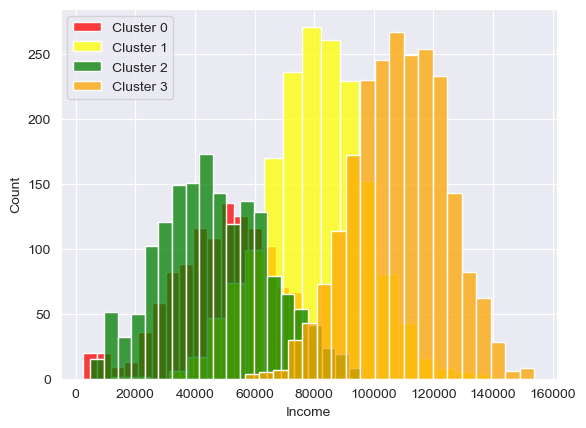

In [1813]:
cluster0 = kprototype_df[kprototype_df.Cluster_kp == 0]
cluster1 = kprototype_df[kprototype_df.Cluster_kp == 1]
cluster2 = kprototype_df[kprototype_df.Cluster_kp == 2]
cluster3 = kprototype_df[kprototype_df.Cluster_kp == 3]


sns.histplot(cluster0['Income'], color='red', label='Cluster 0', bins=20)
sns.histplot(cluster1['Income'], color='yellow', label='Cluster 1', bins=20)
sns.histplot(cluster2['Income'], color='green', label='Cluster 2', bins=20)
sns.histplot(cluster3['Income'], color='orange', label='Cluster 3', bins=20)

plt.legend()

In [1814]:
dists = euclidean_distances(kp.cluster_centroids_)
dists

array([[ 0.        , 11.09053819,  3.17818648, 18.13589136],
       [11.09053819,  0.        ,  8.72558992,  7.75576666],
       [ 3.17818648,  8.72558992,  0.        , 15.76373468],
       [18.13589136,  7.75576666, 15.76373468,  0.        ]])

In [1819]:
kprototype_df.groupby(['Cluster_kp']).mean().transpose().to_csv('output2.csv')

In [1816]:
kprototype_df.head()

,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain,daysAsCardClient,Graduation,HighSchool,Master,PhD,Married,Single,Widow,NumPurchasesTotal,Response_Campaigns,Total_Kids,"age_(17.943, 29.4]","age_(29.4, 40.8]","age_(40.8, 52.2]","age_(52.2, 63.6]","age_(63.6, 75.0]",Cluster_kp
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14594,113947.0,43.0,3.666612,3.529045,3.755951,3.350442,2.750508,2.190332,0.477121,10,0.903090,7,4,0.0,826,1,0,0,0,0,1,0,24,1,0,0,0,1,0,0,3
19070,114297.0,74.0,3.850095,3.565966,3.882012,3.265054,3.086716,1.672098,0.301030,5,1.000000,12,2,0.0,735,1,0,0,0,1,0,0,26,0,0,0,0,1,0,0,3
29888,115476.0,85.0,3.616055,2.580925,3.689398,3.561221,2.580925,1.462398,0.301030,5,0.778151,7,1,0.0,458,0,0,0,1,1,0,0,17,0,0,0,0,0,1,0,3
12221,101172.0,25.0,3.555215,0.000000,3.248219,1.908485,2.257679,1.176091,0.778151,8,0.602060,8,5,0.0,550,1,0,0,0,1,0,0,19,0,2,0,0,1,0,0,1
21107,123128.0,64.0,3.731669,3.051924,3.977541,2.817565,2.750508,1.875061,0.000000,4,0.903090,8,5,0.0,855,0,1,0,0,0,1,0,19,2,0,0,0,1,0,0,3


/var/folders/zb/r83qxb_974vbg2bs9xjz4yvh0000gp/T/ipykernel_68875/1659289959.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Cluster", y="Pct_Vegan&Vegetarian",data=df_final, ci=None)


<AxesSubplot: xlabel='Cluster', ylabel='Pct_Vegan&Vegetarian'>

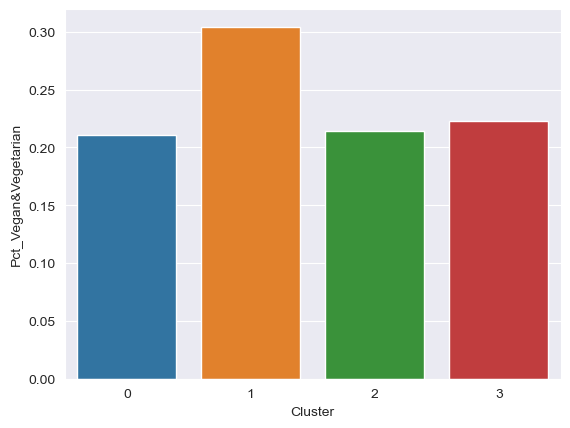

In [1817]:
sns.barplot(x="Cluster", y="Pct_Vegan&Vegetarian",data=df_final, ci=None)

<AxesSubplot: xlabel='Cluster', ylabel='Pct_Store'>

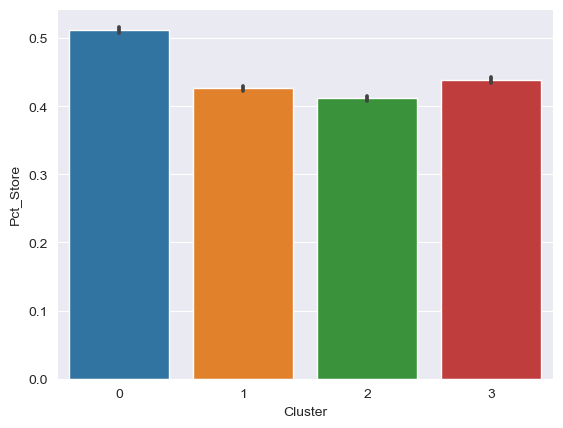

In [1818]:
sns.barplot(x="Cluster", y="Pct_Store", data=df_final)